# Introduction to atomman.lammps

- - -

__Lucas M. Hale__, [lucas.hale@nist.gov](mailto:lucas.hale@nist.gov?Subject=ipr-demo), _Materials Science and Engineering Division, NIST_.

__Chandler A. Becker__, [chandler.becker@nist.gov](mailto:chandler.becker@nist.gov?Subject=ipr-demo), _Office of Data and Informatics, NIST_.

__Zachary T. Trautt__, [zachary.trautt@nist.gov](mailto:zachary.trautt@nist.gov?Subject=ipr-demo), _Materials Measurement Science Division, NIST_.

Version: 2017-06-26

[Disclaimers](http://www.nist.gov/public_affairs/disclaimer.cfm) 
 
- - -

## Introduction

This Notebook provides an introduction to interacting with LAMMPS using the atomman.lammps module.  It provides a working demonstration of how the code works. Links are also given to the in-depth Notebooks related to the specific actions mentioned here.

- - -

Library Imports

In [1]:
#Standard libraries
from __future__ import print_function
import os

#http://www.numpy.org/
import numpy as np             

#http://matplotlib.org/
import matplotlib.pyplot as plt 
%matplotlib inline

#https://github.com/usnistgov/atomman
import atomman as am            
import atomman.lammps as lmp

## 0. Create Demonstration System

Create an fcc Al demonstration unit cell

In [2]:
prop = {'atype':1, 'pos':[[0.0,0.0,0.0], [0.5,0.5,0.0], [0.5,0.0,0.5], [0.0,0.5,0.5]]}
atoms = am.Atoms(natoms=4, prop=prop)
box = am.Box(a=4.05, b=4.05, c=4.05)

fcc_cell = am.System(box=box, atoms=atoms, scale=True)
print(fcc_cell)

avect =  [ 4.050,  0.000,  0.000]
bvect =  [ 0.000,  4.050,  0.000]
cvect =  [ 0.000,  0.000,  4.050]
origin = [ 0.000,  0.000,  0.000]
natoms = 4
natypes = 1
     id |   atype |  pos[0] |  pos[1] |  pos[2]
      0 |       1 |   0.000 |   0.000 |   0.000
      1 |       1 |   2.025 |   2.025 |   0.000
      2 |       1 |   2.025 |   0.000 |   2.025
      3 |       1 |   0.000 |   2.025 |   2.025


## 1. Prepare Systems for LAMMPS

System information can be passed to LAMMPS in a few different ways.

1. The [sys_gen](../reference/atomman.lammps.sys_gen.ipynb) function generates the LAMMPS units, atom_style, boundary, lattice, create_box and create_atoms input command lines based on a seed System. 

2. The [atom_data.dump](../reference/atomman.lammps.atom_data.dump.ipynb) function writes the System information out to a LAMMPS atom data file and generates the associated LAMMPS input command lines.

 Show the LAMMPS command lines constructed for creating a 3x3x3 supercell of fcc_cell generated by the [sys_gen](../reference/atomman.lammps.sys_gen.ipynb) function

In [3]:
print(lmp.sys_gen(ucell = fcc_cell, 
                  size =  [[0,3],[0,3],[0,3]],
                  shift = [0.05, 0.05, 0.05]))

#Atomic system info generated by AtomMan package

units metal
atom_style atomic
boundary p p p 

lattice custom 1.0 &
        a1 4.050000000000 0.000000000000 0.000000000000 &
        a2 0.000000000000 4.050000000000 0.000000000000 &
        a3 0.000000000000 0.000000000000 4.050000000000 &
        origin 0.050000 0.050000 0.050000 &
        spacing 4.050000000000 4.050000000000 4.050000000000 &
        orient x 1 0 0 &
        orient y 0 1 0 &
        orient z 0 0 1 &
        basis 0.000000 0.000000 0.000000 &
        basis 0.500000 0.500000 0.000000 &
        basis 0.500000 0.000000 0.500000 &
        basis 0.000000 0.500000 0.500000

region box block 0 3 0 3 0 3
create_box 1 box
create_atoms 1 box


Create an atom data file using [atom_data.dump](../reference/atomman.lammps.atom_data.dump.ipynb). This is useful for more complicated systems.

In [4]:
sys_info = lmp.atom_data.dump(fcc_cell, 'atom.dat')

Show the returned LAMMPS command lines

In [5]:
print(sys_info)

#Script and atom data file prepared by AtomMan package

units metal
atom_style atomic
boundary p p p 
read_data atom.dat


Show the contents of the data file

In [6]:
with open('atom.dat') as f:
    print(f.read())


4 atoms
1 atom types
0.0 4.0499999999999998 xlo xhi
0.0 4.0499999999999998 ylo yhi
0.0 4.0499999999999998 zlo zhi

Atoms

1 1 0.0000000000000e+00 0.0000000000000e+00 0.0000000000000e+00
2 1 2.0250000000000e+00 2.0250000000000e+00 0.0000000000000e+00
3 1 2.0250000000000e+00 0.0000000000000e+00 2.0250000000000e+00
4 1 0.0000000000000e+00 2.0250000000000e+00 2.0250000000000e+00



## 2. Import Interatomic Potential Information

The design of atomman is such that all parameters associated with running a particular potential in LAMMPS are collected together in [LAMMPS-potential](../data_models/LAMMPS-potential.ipynb) data models, which are then interpreted by the [Potential](../reference/atomman.lammps.Potential.ipynb) class.  

### 2.1 Example LAMMPS-potential data model.  

This generates the [potential-LAMMPS](../data_models/potential-LAMMPS.ipynb) data model file associated with the 2012 MEAM potential by Jelinek, et al.  It is used here as its artifacts can be contained in this Notebook (Section 2.2).

In [7]:
f = open('MEAM-Al-Si-Mg-Cu-Fe--LAMMPS--ipr1.json', 'w')
f.write("""{
    "potential-LAMMPS": {
        "key": "8a039531-1d0f-45cc-b700-209e81ce5f32", 
        "id": "2012--Jelinek-B--Al-Si-Mg-Cu-Fe--LAMMPS--ipr1", 
        "potential": {
            "key": "1515dd80-1984-49de-bc92-d5724059ff56", 
            "id": "2012--Jelinek-B--Al-Si-Mg-Cu-Fe"
        }, 
        "units": "metal", 
        "atom_style": "atomic", 
        "atom": [
            {
                "symbol": "AlS", 
                "element": "Al", 
                "mass": 26.9815
            }, 
            {
                "symbol": "SiS", 
                "element": "Si", 
                "mass": 28.086
            }, 
            {
                "symbol": "MgS", 
                "element": "Mg", 
                "mass": 24.305
            }, 
            {
                "symbol": "CuS", 
                "element": "Cu", 
                "mass": 63.54
            }, 
            {
                "symbol": "FeS", 
                "element": "Fe", 
                "mass": 55.847
            }
        ], 
        "pair_style": {
            "type": "meam"
        }, 
        "pair_coeff": {
            "term": [
                {
                    "file": "Jelinek_2012_meamf"
                }, 
                {
                    "symbolsList": "True"
                }, 
                {
                    "file": "Jelinek_2012_meam.alsimgcufe"
                }, 
                {
                    "symbols": "True"
                }
            ]
        }
    }
}""")
f.close()    

### 2.2 Potential Artifacts.  

This generates the potential artifacts Jelinek_2012_meamf and Jelinek_2012_meam.alsimgcufe indicated in the above data model.  These files were taken from the [NIST Interatomic Potential Repository](http://www.ctcms.nist.gov/potentials/):

In [8]:
#Create MEAM library file "Jelinek_2012_meamf"
f = open('Jelinek_2012_meamf', 'w')
f.write("""# MEAM Al, Si, Mg, Cu, Fe alloy potential, Phys. Rev. B 85, 245102 (2012)
# http://dx.doi.org/10.1103/PhysRevB.85.245102
# to be used with "meam.alsimgcufe" file providing combinational parameters
#  elt        lat     z       ielement     atwt
#  alpha      b0      b1      b2           b3    alat    esub    asub
#  t0         t1              t2           t3            rozero  ibar

'AlS'        'fcc'   12.     13           26.9815
4.64        2.04    3.00    6.0          1.50  4.05    3.353    1.07
1.0         +4.50           -2.30        8.01          1.0    -5
'SiS'        'dia'   4.      14           28.086
4.87        4.4     5.5     5.5          5.5   5.431   4.63    1.
1.0         2.05            4.47         -1.80         2.2    -5
'MgS'       'hcp'   12.      12           24.305
5.52        4.0    3.0     0.2          1.2  3.194 1.51     0.80
1.0         10.04           9.49         -4.3          0.63   -5
'CuS'        'fcc'   12.     29           63.54
5.11        3.634   2.20    6            2.20  3.62    3.54    1.07
1.0         4.91            2.49         2.95          1.10   -5
'FeS'        'bcc'   8       26           55.847
5.0270      3.500   2       1.00         1     2.851   4.28    0.5550
1          -1.6             12.5          -1.40        1.0    -5""")
f.close()

#Create MEAM parameter file "Jelinek_2012_meam.alsimgcufe"
f = open('Jelinek_2012_meam.alsimgcufe', 'w')
f.write("""# MEAM Al, Si, Mg, Cu, Fe alloy potential, Phys. Rev. B 85, 245102 (2012)
# http://dx.doi.org/10.1103/PhysRevB.85.245102
# to be used with "meamf" file providing single element parameters

  Cmin(1,1,1) = 0.8
  repuls(1,1) = 0.1
  Cmin(3,3,3) = 0.8
  Cmin(4,4,4) = 0.8
  Cmin(5,5,5) = 0.68
  repuls(5,5) = 0.3
  Cmax(5,5,5) = 1.9

  nn2(1,1)=1
  nn2(1,2)=1
  nn2(1,3)=1
  nn2(1,4)=1
  nn2(1,5)=1
  nn2(2,2)=1
  nn2(2,3)=1
  nn2(2,4)=1
  nn2(2,5)=1
  nn2(3,3)=1
  nn2(3,4)=1
  nn2(3,5)=1
  nn2(4,4)=1
  nn2(4,5)=1
  nn2(5,5)=1

  lattce(1,2)='b1'
  delta(1,2)=+0.28
  alpha(1,2)=4.56
  re(1,2)=2.62
  Cmin(1,1,2) = 0.50
  Cmin(2,2,1) = 2.00
  Cmin(1,2,1) = 2.00
  Cmin(1,2,2) = 2.00

  lattce(1,3)='b1'
  delta(1,3)=+0.23
  alpha(1,3)=4.52
  re(1,3)=2.87
  Cmin(1,1,3) = 2.00
  Cmin(3,3,1) = 0.00
  Cmin(1,3,1) = 2.00
  Cmin(1,3,3) = 0.00

  lattce(1,4)='b1'
  delta(1,4)=+0.19
  alpha(1,4)=4.65
  re(1,4)=2.53
  Cmin(1,1,4) = 0.00
  Cmin(4,4,1) = 2.00
  Cmin(1,4,1) = 2.00
  Cmin(1,4,4) = 2.00

  lattce(1,5)='b1'
  delta(1,5)=+0.26
  alpha(1,5)=4.64
  re(1,5)=2.45
  Cmin(1,1,5) = 0.90
  Cmin(5,5,1) = 0.10
  Cmin(1,5,1) = 2.00
  Cmin(1,5,5) = 2.00

  lattce(2,3)='b1'
  delta(2,3)=+0.2
  alpha(2,3)=4.73
  re(2,3)=2.75
  Cmin(2,2,3) = 1.00
  Cmin(3,3,2) = 1.00
  Cmin(2,3,2) = 2.00
  Cmin(2,3,3) = 2.00

  lattce(2,4)='b1'
  delta(2,4)=+0.14
  alpha(2,4)=4.74
  re(2,4)=2.46
  Cmin(2,2,4) = 0.00
  Cmin(4,4,2) = 0.00
  Cmin(2,4,2) = 2.00
  Cmin(2,4,4) = 2.00

  lattce(2,5)='b1'
  delta(2,5)=-0.07
  alpha(2,5)=5.17
  re(2,5)=2.39
  Cmin(2,2,5) = 1.00
  Cmin(5,5,2) = 1.00
  Cmin(2,5,2) = 2.00
  Cmin(2,5,5) = 0.00
  attrac(2,5) = 0.1
  repuls(2,5) = 0.1

  lattce(3,4)='b1'
  delta(3,4)=+0.23
  alpha(3,4)=4.70
  re(3,4)=2.63
  Cmin(3,3,4) = 2.00
  Cmin(4,4,3) = 0.00
  Cmin(3,4,3) = 2.00
  Cmin(3,4,4) = 2.00

  lattce(3,5)='b1'
  delta(3,5)=+0.6
  alpha(3,5)=4.96
  re(3,5)=2.61
  Cmin(3,3,5) = 0.65
  Cmin(5,5,3) = 0.00
  Cmin(3,5,3) = 2.00
  Cmin(3,5,5) = 2.00

  lattce(4,5)='b1'
  delta(4,5)=+0.63
  alpha(4,5)=5.21
  re(4,5)=2.42
  Cmin(5,5,4)=0.00

  attrac(5,2) = 0.1
  repuls(5,2) = 0.1

  rc = 5.0
  ialloy=1
  augt1=0
  delr=0.25658351
  emb_lin_neg=1
  bkgd_dyn=1""")
f.close()

### 2.3 Potential Class

The potential information contained in the data model can then be loaded and interpreted by the [Potential](../reference/atomman.lammps.Potential.ipynb) class.  

Load the data model into a Potential instance

In [9]:
meam_potential = lmp.Potential('MEAM-Al-Si-Mg-Cu-Fe--LAMMPS--ipr1.json')

Show the loaded information

In [10]:
print(meam_potential)

2012--Jelinek-B--Al-Si-Mg-Cu-Fe--LAMMPS--ipr1


In [11]:
print(meam_potential.units)

metal


In [12]:
print(meam_potential.atom_style)

atomic


The [Potential.pair_info](../reference/atomman.lammps.Potential.pair_info.ipynb) method will generate the LAMMPS input lines associated with the potential and the atom-model symbols associated with the System's atom types.

In [13]:
print(meam_potential.pair_info(['AlS', 'AlS', 'FeS']))

mass 1 26.981500
mass 2 26.981500
mass 3 55.847000

pair_style meam
pair_coeff * * Jelinek_2012_meamf AlS FeS Jelinek_2012_meam.alsimgcufe AlS AlS FeS



## 3. Creating LAMMPS Input Scripts

Section 1 outlined tools for creating the LAMMPS input script lines associated with the atomic system, and Section 2 outlined how the input script lines associated with a given interatomic potential are accessed.  This modular design supports the reuse and recycling of scripts for different use cases, and allows for high-throughput studies across potentials, system sizes, etc.  The remaining LAMMPS input script lines for a simulation are specific to the application, and thus are left to users.  An example is given here for a NPT run.

Define a function that builds a LAMMPS input script

In [14]:
def npt_script(system_info, pair_info, pressure=0.0, temperature=300.0, timestep=0.01, thermo_steps=100, run_steps=10000):
    """
    Create a LAMMPS script that runs npt on the system.
    
    Keyword Arguments:
    system_info --  string containing LAMMPS commands for creating/reading a system.
    pair_info --    string containing LAMMPS commands specific to the interatomic potential.
    pressure --     pressure to equilibriate the system at. Default is 0.0.
    temperature --  temperature to equilibriate the system at. Default is 300.
    timestep --     timestep to use for the simuation. Default is 0.01.
    thermo_steps -- integer number of steps to compute thermo data.
    run_steps --    integer number of integration steps. Default is 10000.    
    """
    from random import randint
    
    nl = '\n'
    script = nl.join([system_info,
                      '',
                      pair_info,
                      '',
                      'velocity all create %f %i' % (2*temperature, randint(1, 900000000)),
                      '',
                      'thermo %i' % (thermo_steps),
                      'thermo_style custom step temp press lx ly lz',
                      '',
                      'dump mydump all atom %i *.dump' % (run_steps),
                      'timestep %f' % (timestep),
                      'fix 1 all npt temp %f %f %f iso %f %f %f' %(temperature, temperature, 100*timestep, 
                                                                   pressure, pressure, 1000*timestep),
                      'run %i' % (run_steps)])
    return script             

Generate a 3x3x3 supercell of fcc_cell

In [15]:
system = am.supersize(fcc_cell, 3, 3, 3)

Export the system information to an atom data file

In [16]:
system_info = lmp.atom_data.dump(system, 'atom.dat', units=meam_potential.units, atom_style = meam_potential.atom_style)

Call [Potential.pair_info](../reference/atomman.lammps.Potential.pair_info.ipynb) for only AlS

In [17]:
pair_info = meam_potential.pair_info('AlS')

Create an input script using the script generation function

In [18]:
with open('nvt.in', 'w') as inscript:
    inscript.write( npt_script(system_info, pair_info, temperature=100.0) )    

Show the contents of the input script

In [19]:
with open('nvt.in') as inscript:
    print(inscript.read())

#Script and atom data file prepared by AtomMan package

units metal
atom_style atomic
boundary p p p 
read_data atom.dat

mass 1 26.981500

pair_style meam
pair_coeff * * Jelinek_2012_meamf AlS Jelinek_2012_meam.alsimgcufe AlS


velocity all create 200.000000 83318960

thermo 100
thermo_style custom step temp press lx ly lz

dump mydump all atom 10000 *.dump
timestep 0.010000
fix 1 all npt temp 100.000000 100.000000 1.000000 iso 0.000000 0.000000 10.000000
run 10000


## 4. Run LAMMPS

The LAMMPS simulation can be ran from within Python using the [run](../reference/atomman.lammps.run.ipynb) function.

Specify your lammps executable

<div class="alert alert-info">
On nanoHUB, we have to specify which lammps module to use.
</div>

In [20]:
import hublib.use
%use lammps-15May15

lammps_exe = 'lmp_serial'

Run the simulation 

In [21]:
output = lmp.run(lammps_exe, 'nvt.in', return_style='object')

In [22]:
output.simulations[0]['thermo']

,Step,Temp,Press,Lx,Ly,Lz
0,0,200.000000,1646.814900,12.150000,12.150000,12.150000
1,100,128.278400,1471.206800,12.157466,12.157466,12.157466
2,200,102.380960,-1201.855400,12.173371,12.173371,12.173371
3,300,113.445940,-3367.692900,12.185105,12.185105,12.185105
4,400,102.540400,-2745.280900,12.182258,12.182258,12.182258
5,500,94.684010,223.603950,12.166241,12.166241,12.166241
6,600,103.976870,2793.834500,12.150654,12.150654,12.150654
7,700,101.863540,2966.704600,12.149899,12.149899,12.149899
8,800,101.834310,570.621660,12.164836,12.164836,12.164836
9,900,105.846040,-2345.845900,12.181014,12.181014,12.181014


## 5. Analyzing Thermo Results

The [run](../reference/atomman.lammps.run.ipynb) function extracts the log.lammps thermo data into either a pandas.DataFrame or as an easily searchable [DataModelDict](https://github.com/usnistgov/DataModelDict). Alternatively, the [log_extract](../reference/atomman.lammps.log_extract.ipynb) function can do the same thing for LAMMPS log files.

Plot temperature vs. run step

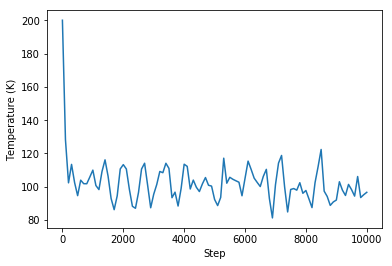

In [23]:
steps = output.simulations[0]['thermo'].Step
temps = output.simulations[0]['thermo'].Temp

plt.plot(steps, temps)
plt.xlabel('Step')
plt.ylabel('Temperature (K)')
plt.show()

## 6 Reading in dump files 

Resulting LAMMPS dump files can be read in with the [atom_dump.load](../reference/atomman.lammps.atom_dump.load.ipynb) function.  

In [24]:
system = lmp.atom_dump.load('10000.dump')
print(system)

avect =  [12.168,  0.000,  0.000]
bvect =  [ 0.000, 12.168,  0.000]
cvect =  [ 0.000,  0.000, 12.168]
origin = [-0.009, -0.009, -0.009]
natoms = 108
natypes = 1
     id |   atype |  pos[0] |  pos[1] |  pos[2]
      0 |       1 |  -0.001 |  -0.041 |  -0.062
      1 |       1 |   1.995 |   2.033 |  -0.061
      2 |       1 |   2.049 |   0.003 |   1.934
      3 |       1 |   0.035 |   1.985 |   2.011
      4 |       1 |   3.996 |  -0.030 |   0.010
      5 |       1 |   6.005 |   2.031 |  -0.071
      6 |       1 |   6.016 |   0.094 |   2.052
      7 |       1 |   4.057 |   1.983 |   1.998
      8 |       1 |   8.109 |   0.027 |   0.035
      9 |       1 |  10.100 |   1.978 |   0.048
     10 |       1 |  10.123 |  -0.015 |   2.049
     11 |       1 |   8.172 |   1.976 |   2.029
     12 |       1 |   0.006 |   4.109 |  -0.055
     13 |       1 |   2.104 |   6.088 |   0.054
     14 |       1 |   2.012 |   4.077 |   2.033
     15 |       1 |  -0.079 |   6.153 |   2.038
     16 |       1 |   3

## 7. Summary

This section collects all of the atomman.lammps functions associated with the demonstration, and reruns the simulation.

In [25]:
#load Potential
meam_potential = lmp.Potential('MEAM-Al-Si-Mg-Cu-Fe--LAMMPS--ipr1.json')
    
#write system to data file
system_info = lmp.atom_data.dump(system, 'atom.dat', units=meam_potential.units, atom_style=meam_potential.atom_style)

#get pair_info
pair_info = meam_potential.pair_info('AlS')

#create input script
with open('nvt.in', 'w') as inscript:    
    inscript.write( npt_script(system_info, pair_info, temperature=100.0) )

#run LAMMPS
output = lmp.run(lammps_exe, 'nvt.in')    

#read in final system info from dump file
system = lmp.atom_dump.load('10000.dump')

File Cleanup

In [26]:
os.remove('log.lammps')
os.remove('atom.dat')
os.remove('Jelinek_2012_meam.alsimgcufe')
os.remove('Jelinek_2012_meamf')
os.remove('MEAM-Al-Si-Mg-Cu-Fe--LAMMPS--ipr1.json')
os.remove('nvt.in')
os.remove('10000.dump.json')

#remove dump files
flist = os.listdir(os.getcwd())
for fname in flist:
    if fname[-5:] == '.dump':
        os.remove(fname)       